In [2]:
import geopandas as gp
import matplotlib.pyplot as plt

from shapely.ops import unary_union
from shapely.geometry import Polygon

import numpy as np

from datetime import timedelta, datetime

In [3]:
tes = gp.read_file(r'iho\iho.shp')
df = tes.loc[tes.name.isin(['South Atlantic Ocean', 'North Atlantic Ocean'])]
df

,name,id,longitude,latitude,min_x,min_y,max_x,max_y,area,mrgid,geometry
7,South Atlantic Ocean,32,-18.808767,-33.732396,-69.600837,-60.000000,20.009049,0.075106,40501812.0,1914,"POLYGON ((8.97417 -0.93603, 8.97515 -0.93592, ..."
9,North Atlantic Ocean,23,-37.624244,29.480034,-83.014914,-0.002563,6.619967,68.638716,34507128.0,1912,"POLYGON ((-6.26384 62.34582, -6.17706 62.32412..."


<AxesSubplot:>

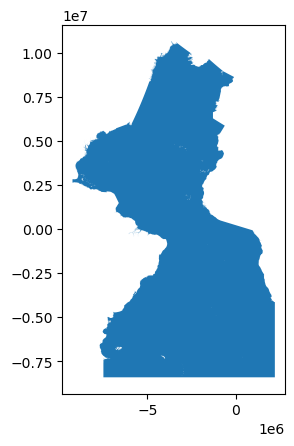

In [4]:
atlantic = df.dissolve().to_crs(epsg=3857)
atlantic.plot()

In [5]:
atlantic.geometry[0].bounds

(-9241177.971966805,
 -8399737.889818331,
 2227397.1613292582,
 10639472.197641218)

In [6]:
xmin, ymin, xmax, ymax = atlantic.geometry[0].bounds

# 10 x 10 km wide squares
length = 10000
wide = 10000

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))


polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gp.GeoDataFrame({'geometry':polygons})
grid

,geometry
0,"POLYGON ((-9241177.972 -8399737.890, -9231177...."
1,"POLYGON ((-9241177.972 -8389737.890, -9231177...."
2,"POLYGON ((-9241177.972 -8379737.890, -9231177...."
3,"POLYGON ((-9241177.972 -8369737.890, -9231177...."
4,"POLYGON ((-9241177.972 -8359737.890, -9231177...."
...,...
2183883,"POLYGON ((2218822.028 10590262.110, 2228822.02..."
2183884,"POLYGON ((2218822.028 10600262.110, 2228822.02..."
2183885,"POLYGON ((2218822.028 10610262.110, 2228822.02..."
2183886,"POLYGON ((2218822.028 10620262.110, 2228822.02..."


In [7]:
data_points = grid.sample(n=10000, random_state=1)
data_points.crs = 3857
data_points

,geometry
947500,"POLYGON ((-4271177.972 3720262.110, -4261177.9..."
1422807,"POLYGON ((-1771177.972 -3209737.890, -1761177...."
1303702,"POLYGON ((-2401177.972 5260262.110, -2391177.9..."
613918,"POLYGON ((-6021177.972 -99737.890, -6011177.97..."
298751,"POLYGON ((-7681177.972 8870262.110, -7671177.9..."
...,...
1031540,"POLYGON ((-3831177.972 6360262.110, -3821177.9..."
920902,"POLYGON ((-4411177.972 4300262.110, -4401177.9..."
726220,"POLYGON ((-5431177.972 -439737.890, -5421177.9..."
1740689,"POLYGON ((-101177.972 -4069737.890, -91177.972..."


In [1]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [9]:
def extract_raster_values_from_df(df, image_collection, band_names, task_name, date, lookback_days=3, scale=5000, export=False):
    df['ee_region'] = df.geometry.apply(lambda x: ee.Geometry.Polygon(list((x.exterior.coords)), proj='EPSG:4326'))
    regionCollection = ee.List([])
    emptyCol = ee.FeatureCollection(ee.Feature(None))
    
    # iterate through all entries
    for row in df.itertuples():
        # instantiate the image collection for the selected time series
        collection = ee.ImageCollection(image_collection).filterDate((date - timedelta(days=lookback_days)).strftime('%Y-%m-%d'), date.strftime('%Y-%m-%d')).select(band_names)
        
        # get the raster information based on the buffer region we created
        pixelInfoRegion = collection.getRegion(geometry=getattr(row, 'ee_region'), scale=scale)

        # remove the first element, which is the header ['id', 'longitude', 'latitude', 'time', 'velocity_u_0', 'velocity_v_0']
        pixelInfoRegion = pixelInfoRegion.remove(pixelInfoRegion.get(0))
        # convert the 2d list of information to features. Going to hard code this part as I cba
        def func(x):
            x = ee.List(x)
            feat = ee.Feature(ee.Geometry.Point([x.get(1), x.get(2)], proj='EPSG:4326'), {'time':x.get(3),'velocity_u_0':x.get(4),'velocity_v_0':x.get(5)})
            return feat
        col = ee.FeatureCollection(pixelInfoRegion.map(func))
        # add the region that we created to the overall feature collection
        
        # ensure collection is not empty bands
        regionCollection = regionCollection.add(ee.Algorithms.If(collection.size(), col, emptyCol))
    
    if export:
        return ee.batch.Export.table.toDrive(collection=ee.FeatureCollection(regionCollection).flatten(), description=task_name, fileFormat="csv", folder="exported_files")
    else:
        return ee.FeatureCollection(regionCollection).flatten()

Latest hycom date is 2022-09-12. Kernel keeps crashing when we task.start() for too many points.

In [10]:
size = 500
for i in range(0, 10000, size):
    task_name = f"atlantic_water_velocities_{i}"
    task = extract_raster_values_from_df(data_points.iloc[i:i+size].copy(), 'HYCOM/sea_water_velocity', ['velocity_u_0', 'velocity_v_0'], task_name, datetime(2022,9,12), export=True)
    task.start()